<h1><center>Modelo Clasificador de Comunas</center></h1>

#### Decidimos crear un modelo supervisado clasificador que prediga como salida la comuna a la que pertenece una lista semanal de pesajes  que ingresa como entrada. 
#### Nuestra hipotesis es que las comunas tienen combinaciones distintas de distribuciones para cada pesaje, lo que les otorga una cualidad unica para, en caso de detectarla, poder predecir de que comuna es una lista semanal de pesajes.

#### Realizamos un Filtrado de Outliers, para que nuestro modelo no este sesgado por anomalías. Como vimos en el EDA lo más optimo seria filtrar los outliers de cada comuna por separado ya que hay grandes diferencias entre cada una y queremos que nuestro modelo pueda percibir estas diferencias para poder clasificarlas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import functools as ft
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm, datasets
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import warnings; warnings.filterwarnings('ignore')

In [2]:
filename = r'C:\Users\DeMartinCal\Desktop\reciclaje\pesajes_nulos.csv'
pesajes = pd.read_csv(filename, delimiter=';', decimal='.')

In [3]:
# Traducimos las comunas a solamente un numero

comunas_distintas_Pesajes = ['COMUNA 1', 'COMUNA 2', 'COMUNA 3', 'COMUNA 4', 'COMUNA 5', 'COMUNA 6', 'COMUNA 7','COMUNA 8',
                             'COMUNA 9', 'COMUNA 10', 'COMUNA 11', 'COMUNA 12', 'COMUNA 13', 'COMUNA 14', 'COMUNA 15']
for i in range (1,16):
    pesajes.loc[ pesajes['COMUNA'] == comunas_distintas_Pesajes[i-1], 'COMUNA'] = i

In [4]:
## Obtenemos los percentiles 97 de cada pesaje y filtro mi dataset por cada uno

quantile = 0.97
pesajes2 = pesajes.head(0).copy()
for comuna in range(1,16):
    pesajes2 = pd.concat([pesajes2,pesajes.loc[pesajes['COMUNA'] == comuna].loc[(pesajes.loc[pesajes['COMUNA'] == comuna]['VIDRIO'] < pesajes.loc[pesajes['COMUNA'] == comuna]['VIDRIO'].quantile(quantile)) &
                          (pesajes.loc[pesajes['COMUNA'] == comuna]['PAPEL_Y_CARTON'] < pesajes.loc[pesajes['COMUNA'] == comuna]['PAPEL_Y_CARTON'].quantile(quantile)) &
                          (pesajes.loc[pesajes['COMUNA'] == comuna]['METAL'] < pesajes.loc[pesajes['COMUNA'] == comuna]['METAL'].quantile(quantile)) &
                          (pesajes.loc[pesajes['COMUNA'] == comuna]['TELGOPOR'] < pesajes.loc[pesajes['COMUNA'] == comuna]['TELGOPOR'].quantile(quantile)) &
                          (pesajes.loc[pesajes['COMUNA'] == comuna]['TETRA_BRICK'] < pesajes.loc[pesajes['COMUNA'] == comuna]['TETRA_BRICK'].quantile(quantile)) &
                          (pesajes.loc[pesajes['COMUNA'] == comuna]['PLASTICOS_TODOS_LOS_DEMAS'] < pesajes.loc[pesajes['COMUNA'] == comuna]['PLASTICOS_TODOS_LOS_DEMAS'].quantile(quantile))]])
pesajes = pesajes2
print(f"Luego de filtrar los outliers de cada comuna me quedo con {np.shape(pesajes2)[0]} filas")

Luego de filtrar los outliers de cada comuna me quedo con 2181 filas


In [5]:
## Separamos el dataset en X (entrada) Y (salida a predecir)

x = pesajes.iloc[:,2:] 
y = pesajes.iloc[:,1]

In [6]:
## Separamos las entradas y salidas en Train y Test para realizar el metodo Cross Validation

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3, random_state=4)

In [7]:
## Realizamos feature selection filtrando por el desvio y cuantil del train

# Umbral para definir con que % de features nos quedamos
thresh = 0.2

Features_Seleccionadas = (np.std(xtrain)>np.quantile(np.std(xtrain), thresh)).values
Features_Seleccionadas[0:2] = True # Dejo las fechas 
xtrain = xtrain.iloc[:,Features_Seleccionadas]
xtest = xtest.iloc[:,Features_Seleccionadas]

In [8]:
print("La cantidad de Features seleccionadas son " + str(np.shape(xtrain)[1]))

La cantidad de Features seleccionadas son 8


In [9]:
## Autoescalamos los datos usando StandardScaler

scaler = preprocessing.StandardScaler().fit(xtrain)
scaler

StandardScaler(copy=True, with_mean=True, with_std=True)

In [10]:
## xtrain_scal tendra el dataset de train pre-procesado con el standard scaler
xtrain_scal = scaler.transform(xtrain)

## para cada feature imprimimos la media y el desvio standard obtenido.
# Veo que me queda media casi 0 y desvío 1
print(xtrain_scal.mean(axis=0))
print(xtrain_scal.std(axis=0))

[-1.58610274e-13 -9.19608062e-17  1.53656031e-16  1.07093597e-16
 -1.11749840e-16 -5.35467986e-17 -2.42124654e-16 -1.62968517e-17]
[1. 1. 1. 1. 1. 1. 1. 1.]


In [11]:
## Utilizando el scaler ajustado a los datos de train, aplicamos el scaler a los 
# datos de test. Obtenemos "xtest_scal" 

xtest_scal = scaler.transform(xtest)

# Veo que me quedan media y desvío muy cercanos a 0 y 1 ya que no fueron ajustados con Test
print(xtest_scal.mean(axis=0))
print(xtest_scal.std(axis=0))

[-0.01689409 -0.02050102 -0.07352324 -0.08282721 -0.07052091 -0.03678148
 -0.07628432 -0.05634483]
[0.99586784 0.95180574 0.94001267 0.89096717 0.97945567 0.89652859
 0.93651271 0.98153244]


### Creamos un modelo evaluando 3 algorimos de clasificación distintos: KNN, SVM y Logistic Regresion

### K-nearest neighbors

In [12]:
## Realizo un ciclo de pruba para buscar cual es la cantidad de vecinos mas efectiva
#  para el modelo. Creo un vector de 50 posiciones para guardar los resultados de accuracy.

iteraciones_knn = 50
acc_knn = np.zeros(iteraciones_knn)

for r in range(0,iteraciones_knn):
    neigh = KNeighborsClassifier(n_neighbors=r+1)
    neigh.fit(xtrain_scal,ytrain)
    ypred_knn = neigh.predict(xtest_scal)
    acc_knn[r] = accuracy_score(ytest, ypred_knn)

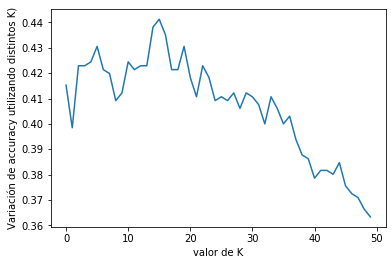

In [13]:
## Imprimimos en pantalla el accuracy para cada valor de K

plt.plot(acc_knn)
plt.xlabel("valor de K")
plt.ylabel("Variación de accuracy utilizando distintos K)")
plt.show()

In [14]:
## Defino modelo KNN de 5 vecinos

neigh = KNeighborsClassifier(n_neighbors=5)

In [15]:
## Ajusto mi modelo a las muestras de training utilizando tanto Xtrain como Ytrain

neigh.fit(xtrain_scal, ytrain) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [16]:
## Genero predicciones entrenado para las muestras de Test, utilizando solo Xtest

ypred = neigh.predict(xtest_scal)

In [17]:
## Computo el accuracy (comparar ytest vs ypred)

test_acc = accuracy_score(ytest, ypred)
print("El accuracy es " + str(test_acc))

El accuracy es 0.42442748091603055


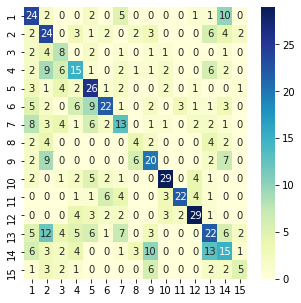

In [18]:
# Computo la matriz de confusión y la visualizo con un Heatmap

cm = confusion_matrix(ytest, ypred)

df_cm = pd.DataFrame(cm, index = [i for i in np.unique(y)], columns = [i for i in np.unique(y)])
plt.figure(figsize = (5,5))
sns.heatmap(df_cm, annot=True, cmap="YlGnBu")
plt.show()

### Support Vector Machines

In [19]:
## Realizamos un GridSearch usando SVM con kernel gaussiano y Cross Validation de 10 Folds

parameters = [{'kernel': ['rbf'], 'gamma': [0.01,0.1,1,10],'C': [1,3,5,10]}]

# Creamos el modelo
svc = svm.SVC()

# Definimos el GridSearch con los parametros elegidos
clf = GridSearchCV(svc, param_grid = parameters, refit = True, cv = 10)
clf.fit(xtrain_scal, ytrain.ravel())
scores = clf.cv_results_

In [20]:
print("Los mejores parametros son %s con un puntaje de %0.2f" %(clf.best_params_, clf.best_score_))

Los mejores parametros son {'C': 3, 'gamma': 1, 'kernel': 'rbf'} con un puntaje de 0.48


In [21]:
# Predecimos las muestras de test
y_pred=clf.predict(xtest_scal) 
print(f"Se obtuvo una accuracy de {clf.score(xtest_scal,ytest.ravel())}")

Se obtuvo una accuracy de 0.4900763358778626


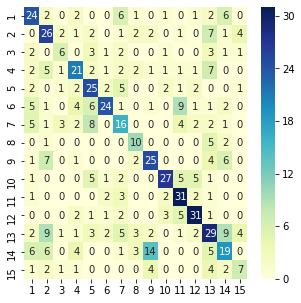

In [22]:
# Computo la matriz de confusión y la visualizo con un Heatmap

cm = confusion_matrix(ytest, y_pred)

df_cm = pd.DataFrame(cm, index = [i for i in np.unique(y)],columns = [i for i in np.unique(y)])
plt.figure(figsize = (5,5))
sns.heatmap(df_cm, annot=True, cmap="YlGnBu")
plt.show()

### Logistic Regression

In [23]:
## Creo el modelo de regresion logistica

lr_model = LogisticRegression(random_state=42, solver='lbfgs')

In [24]:
## Entreno el modelo
lr_model.fit(xtrain_scal, ytrain) 

# Genero predicciones con mi modelo entrenado para las muestras de Test, utilizando solo Xtest
ypred = lr_model.predict(xtest_scal)

# Computo el accuracy (comparar ytest vs ypred)
test_acc2 = accuracy_score(ytest, ypred)
print("El accuracy es " + str(test_acc2))

El accuracy es 0.32213740458015266


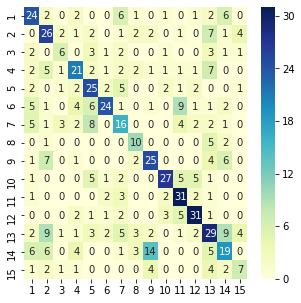

In [25]:
# Computo la matriz de confusión y la visualizo con un Heatmap

cm = confusion_matrix(ytest, y_pred)
df_cm = pd.DataFrame(cm, index = [i for i in np.unique(y)], columns = [i for i in np.unique(y)])
plt.figure(figsize = (5,5))
sns.heatmap(df_cm, annot=True, cmap="YlGnBu")
plt.show()

## El mejor modelo predictivo lo conseguimos usando SVM con Costo 3 y un Kernel Gaussiano de gamma 1. Logramos una Accuracy del 50% para predecir entre 15 etiquetas distintas que representan las 15 comunas.